In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv1D,MaxPooling1D,UpSampling1D,Flatten,add
from tensorflow.keras.callbacks import ModelCheckpoint

from AD_tools import * # specifically need training()

In [2]:
plt.rcParams.update({
    'figure.figsize': (6,5),
    'font.size': 16,
    })

In [37]:
name = "3-0"

In [38]:
data = np.loadtxt("data/dataD10s_cut03.txt")
data.shape

(400, 43)

In [39]:
xx, yy = data[:,0], data[:,1]

In [40]:
sorter = np.argsort(xx)
xx, yy = xx[sorter], yy[sorter]

In [41]:
x_data = data[:,3:][sorter]

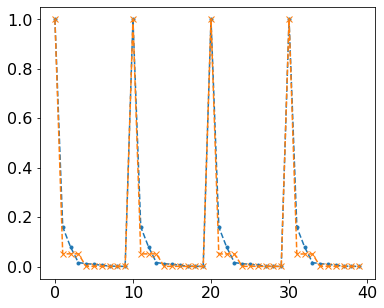

In [42]:
plt.plot(x_data[0],".--")
plt.plot(x_data[-1],"x--")

In [43]:
x_test = x_data.reshape((x_data.shape[0],4,10)).transpose((0,2,1))
x_test.shape

(400, 10, 4)

In [44]:
x_test = x_test[:,1:,:]
x_test.shape

(400, 9, 4)

In [45]:
shape_ = x_test.shape[1:]

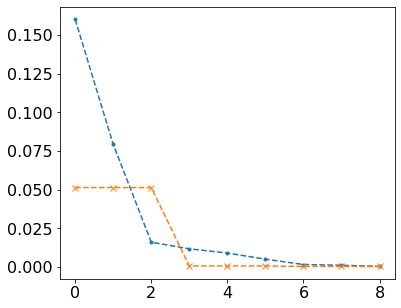

In [46]:
plt.plot(x_test[0,:,0],".--")
plt.plot(x_test[-1,:,0],"x--")

In [47]:
def picker(fillings, fmin, fmax):
    fillings = np.array(fillings)
    pickle = np.where((fillings>= fmin) & (fillings <= fmax))
    return pickle, fillings[pickle]

In [48]:
rate=0.2 # Dropout percentage
bottleneck = 50 # latent space dimension, does not make great differences
fully = True

In [49]:
def cnnx(loss,optimizer,activation0,activation,x_shape,dim1=(16,(3,)),dim2=(16,(3,)), fully=False):
    """ 
    Pretty Standard Convolutional Autoencoder with a fully-connected latent space
    activation0: Activations "inside" the CAE
    activation: Last activation (important depending on the range of the pixel values)
    """
    in_dim = x_shape
    input_img = Input(shape=in_dim)
   
    #x1 = Conv1D(*dim1, activation=activation0, padding='same')(input_img)
    #x2 = MaxPooling1D((2,), padding='same')(x1)
    #x2 = Conv1D(*dim2, activation=activation0, padding='same')(x2)
    #x3 = MaxPooling1D((2,), padding='same')(x2)
    #encoded = Conv1D(*dim2, activation=activation0, padding='same')(x2)
    
    encoded = Flatten()(input_img)
    encoded = Dense(units=100,activation=activation0)(encoded)
    encoded = tf.keras.layers.Dropout(rate)(encoded)
    encoded = Dense(units=25,activation=activation0)(encoded)
    
    y = Dense(units=100,activation=activation0)(encoded)
    y = tf.keras.layers.Dropout(rate)(y)

    #y=UpSampling1D(2)(encoded)
    #y=Conv1D(*dim1, activation=activation0, padding='same')(y)
    #y=UpSampling1D(2)(y)
    decoded = Dense(np.prod(in_dim), activation=activation)(y)
    decoded = tf.keras.layers.Reshape(in_dim)(decoded)
    

    cnn = Model(input_img, decoded)
    cnn.compile(loss=loss,optimizer=optimizer)
    return cnn

In [50]:
# Show Network architecture
cnn = cnnx("mse","adam","linear","relu",x_shape=(10,4))
cnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 4)]           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               4100      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_18 (Dense)             (None, 100)               2600      
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0   

In [51]:
def create_out(cnn1):
    """
    Creates (dim_freq, dim_phase) matrix of the output loss and the standard deviation
    """
    y_test = cnn1.predict(x_test)
    return 100*eval_loss(x_test,y_test,norm=norm2)/eval_loss(x_test,0*x_test,norm=norm2)

In [56]:
train1s = [(0,0.01),(3.99,np.max(xx)),(1.5,1.51)]

In [57]:
for i in range(len(x_test)):
    x_test[i] = x_test[i]/np.mean(x_test[i])

# Training
This actually takes quite a while because it cant parallelize anything. So it is not very desireable to train with just one example

In [58]:
cnns = [None]*len(train1s)
outs = [None]*len(train1s)

1 4000 4000


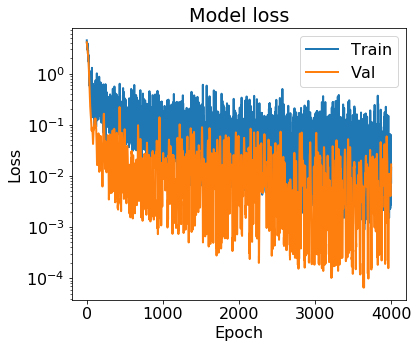

1 4000 4000


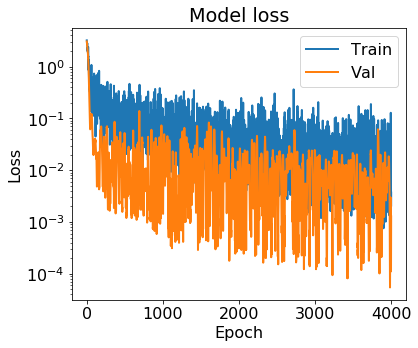

1 4000 4000


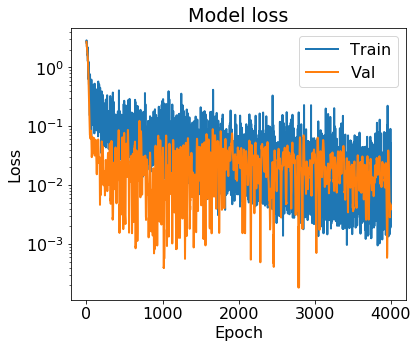

In [59]:
for i,train1 in enumerate(train1s):
    pickle, xx_train = picker(xx,*train1)
    x_train = x_test[pickle]
    x_train = x_train[:1]
    num_epochs = 4000//len(x_train)
    print(len(x_train), num_epochs, len(x_train) * num_epochs)
    cnns[i] = training(x_train = x_train,choose_cnn = cnnx, name = name, provide_cnn = False,
                 load_prev= False, num_epochs = num_epochs,  verbose_val=0, batch_size = 16, shuffle=True, early=False,
                 loss="mse", activation0 = 'relu', activation = 'linear', optimizer = "adam",
                 dim1=(16,(3,)), dim2=(16,(3,)), x_shape = shape_)
    outs[i] = create_out(cnns[i])

In [61]:
outs = np.array(outs)

In [64]:
np.savez("data_results/3-0_data",xx=xx,outs=outs,train1s=train1s)

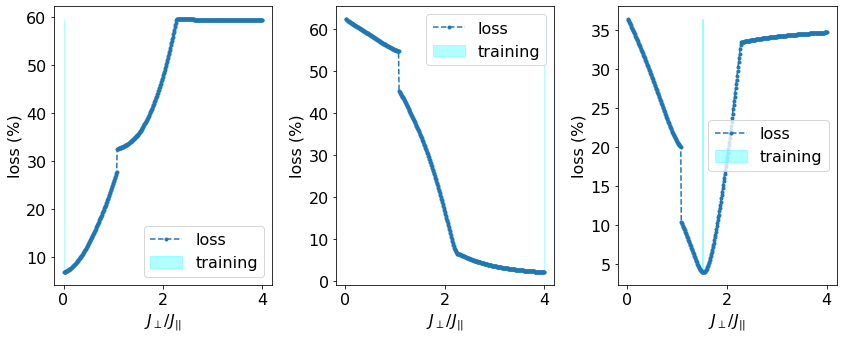

In [63]:
fig, axs = plt.subplots(ncols=3,figsize=(12,5))
for i,train1 in enumerate(train1s):
    ax = axs[i]
    out = outs[i]
    ax.plot(xx,out,".--",label="loss")
    ax.set_ylabel("loss (%)")
    ax.set_xlabel("$J_\perp/J_{{||}}$")
    ax.fill_between(*[train1],out.min(),out.max(),alpha=0.3,color="cyan", label="training")
    ax.legend()
    plt.tight_layout()
    
plt.tight_layout()
plt.savefig("plots/" + name + ".png")